In [72]:
# 安裝需要的套件（若已安裝可跳過）
!pip install -q kaggle pandas numpy matplotlib seaborn scikit-learn statsmodels openpyxl

# 載入 Python 常用套件，後面會用到
import os                                   # 檔案路徑處理
import glob                                 # 檔案搜尋
import pandas as pd                         # 資料處理
import numpy as np                          # 數值運算
import matplotlib.pyplot as plt             # 繪圖
import seaborn as sns                       # 進階繪圖
from sklearn.model_selection import train_test_split, KFold, cross_val_score  # 分割與交叉驗證
from sklearn.linear_model import LinearRegression, LassoCV                     # 線性模型
from sklearn.feature_selection import SelectKBest, f_regression, RFE          # 特徵選擇
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # 評估指標
import statsmodels.api as sm                # statsmodels（取得信賴區間）
import warnings                             # 忽略警告訊息（視需求）
warnings.filterwarnings('ignore')           # 關閉不必要的警告


In [73]:
# 設定 Kaggle 認證路徑，請確認 kaggle.json 放在該資料夾中
kaggle_config_dir = r"D:\test"              # <-- 如果你的 kaggle.json 在別處，請修改這裡
os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir

# 顯示 kaggle.json 是否存在（檢查）
kaggle_json_path = os.path.join(kaggle_config_dir, 'kaggle.json')
print("期望的 kaggle.json 路徑：", kaggle_json_path)
print("kaggle.json 是否存在：", os.path.exists(kaggle_json_path))


期望的 kaggle.json 路徑： D:\test\kaggle.json
kaggle.json 是否存在： True


In [74]:
# 透過 Kaggle CLI 下載 Automobile Dataset（slug: hellbuoy/car-price-prediction）
dataset_slug = "hellbuoy/car-price-prediction"  # 若要換其他資料集請修改這行
download_dir = "./data_car"                     # 下載存放的資料夾

# 建立資料夾（若不存在）
os.makedirs(download_dir, exist_ok=True)

# 使用 kaggle 下載並解壓（若 kaggle.json 有誤，指令會報錯）
!kaggle datasets download -d {dataset_slug} -p {download_dir} --unzip

# 列出下載後資料夾內容，方便確認檔名
print("下載資料夾內容：")
print(glob.glob(download_dir + "/*"))


Dataset URL: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction
License(s): unknown

下載資料夾內容：
['./data_car\\CarPrice_Assignment.csv', './data_car\\Data Dictionary - carprices.xlsx']



  0%|          | 0.00/18.1k [00:00<?, ?B/s]
100%|██████████| 18.1k/18.1k [00:00<?, ?B/s]


In [75]:
# 自動尋找 download_dir 下的第一個 CSV 檔並讀取
import glob
csv_files = glob.glob(os.path.join(download_dir, "*.csv"))
print("找到的 CSV 檔案：", csv_files)

# 如果沒有找到 CSV，直接檢視資料夾內容以便手動處理
if len(csv_files) == 0:
    print("未找到 CSV 檔案，請確認下載內容：", os.listdir(download_dir))
else:
    # 讀取第一個 CSV 為 DataFrame
    csv_path = csv_files[0]
    print("讀取檔案：", csv_path)
    df = pd.read_csv(csv_path)
    print("資料讀取完成，資料形狀：", df.shape)
    display(df.head(6))


找到的 CSV 檔案： ['./data_car\\CarPrice_Assignment.csv']
讀取檔案： ./data_car\CarPrice_Assignment.csv
資料讀取完成，資料形狀： (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
5,6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.0


In [76]:
# 檢查資料基本資訊：欄位、資料型態與缺失值
print("欄位清單：")
print(df.columns.tolist())

print("\n資料型態：")
print(df.dtypes)

print("\n缺失值統計（每個欄位）：")
print(df.isna().sum())

# 顯示數值欄位的描述性統計
print("\n數值欄位描述統計：")
display(df.describe().T)

# 顯示每個類別欄位前幾個值（若有類別欄）
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("\n類別欄位及其值分布（每個欄位列出前 10 個值）：")
for c in cat_cols:
    print("-----", c)
    print(df[c].value_counts().head(10))


欄位清單：
['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']

資料型態：
car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int6

,count,mean,std,min,25%,50%,75%,max
car_ID,205.0,103.000000,59.322565,1.00,52.00,103.00,154.00,205.00
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17



類別欄位及其值分布（每個欄位列出前 10 個值）：
----- CarName
CarName
toyota corona           6
toyota corolla          6
peugeot 504             6
subaru dl               4
mitsubishi mirage g4    3
mazda 626               3
toyota mark ii          3
mitsubishi outlander    3
mitsubishi g4           3
honda civic             3
Name: count, dtype: int64
----- fueltype
fueltype
gas       185
diesel     20
Name: count, dtype: int64
----- aspiration
aspiration
std      168
turbo     37
Name: count, dtype: int64
----- doornumber
doornumber
four    115
two      90
Name: count, dtype: int64
----- carbody
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64
----- drivewheel
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64
----- enginelocation
enginelocation
front    202
rear       3
Name: count, dtype: int64
----- enginetype
enginetype
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv     

In [77]:
# 複製一份資料以免覆寫原始 df
df_clean = df.copy()

# 範例：如果某些欄位用 "?" 表示缺值，先把它們換成 np.nan
df_clean.replace("?", np.nan, inplace=True)

# 嘗試把數值型欄位轉為 numeric（若原被讀成 object）
# 這裡會嘗試對所有 object 欄位進行轉 numeric（不能轉的會變 NaN）
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # 將可轉為數值的欄位轉為 numeric（errors='ignore' 保留原值）
        df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')

# 再次檢查缺失值情況
print("轉換後缺失值統計：")
print(df_clean.isna().sum())

# 簡單處理缺值策略：
# - 數值欄位以中位數填補
# - 類別欄位以眾數填補
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()

# 數值欄位填中位數
for c in num_cols:
    if df_clean[c].isna().sum() > 0:
        df_clean[c].fillna(df_clean[c].median(), inplace=True)

# 類別欄位填眾數
for c in obj_cols:
    if df_clean[c].isna().sum() > 0:
        df_clean[c].fillna(df_clean[c].mode().iloc[0], inplace=True)

# 檢查處理後的缺失值
print("\n缺失值處理後：")
print(df_clean.isna().sum())


轉換後缺失值統計：
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

缺失值處理後：
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0


In [78]:
# 根據 automobile dataset 的常見欄位，通常目標為「price」或類似名稱
# 先嘗試自動尋找可能的目標欄位
possible_targets = ["price", "Price", "sellingprice", "SalePrice", "cost"]
target = None
for t in possible_targets:
    if t in df_clean.columns:
        target = t
        break

# 如果沒有在上面找到，則使用最後一個數值欄位當作預設 target（並提醒使用者）
if target is None:
    num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) == 0:
        raise ValueError("資料中找不到數值欄位可當作目標（target），請檢查資料集。")
    target = num_cols[-1]   # 預設使用最後一個數值欄
    print("未偵測到常用 target 欄位，預設使用：", target)
else:
    print("偵測到的 target 欄位為：", target)

# 分離特徵 X 與目標 y
X = df_clean.drop(columns=[target]).copy()
y = df_clean[target].copy()

# 列出特徵數量與前幾個欄位
print("特徵數量：", X.shape[1])
print("前 10 個特徵：", X.columns.tolist()[:10])


偵測到的 target 欄位為： price
特徵數量： 25
前 10 個特徵： ['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase']


In [79]:
# 先把類別欄位用 One-Hot Encoding 編碼（drop_first=True 避免多重共線性）
X_encoded = pd.get_dummies(X, drop_first=True)

# 若需要標準化可以在之後加入，但對線性回歸非必要（視模型而定）
# 這裡僅顯示編碼後的欄位數與前幾個欄位名稱
print("One-Hot Encoding 後特徵數：", X_encoded.shape[1])
print("前 30 個欄位：", X_encoded.columns.tolist()[:30])


One-Hot Encoding 後特徵數： 190
前 30 個欄位： ['car_ID', 'symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'CarName_alfa-romero Quadrifoglio', 'CarName_alfa-romero giulia', 'CarName_alfa-romero stelvio', 'CarName_audi 100 ls', 'CarName_audi 100ls', 'CarName_audi 4000', 'CarName_audi 5000', 'CarName_audi 5000s (diesel)', 'CarName_audi fox', 'CarName_bmw 320i', 'CarName_bmw x1', 'CarName_bmw x3', 'CarName_bmw x4', 'CarName_bmw x5', 'CarName_bmw z4']


In [80]:
# 把資料切成訓練集與測試集（80% 訓練，20% 測試）
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 顯示切分後的形狀
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)


X_train shape: (164, 190)
X_test shape : (41, 190)
y_train shape: (164,)
y_test shape : (41,)


In [81]:
# 計算每個數值特徵與目標的 Pearson 相關係數（若編碼後為數值）
# 先把訓練集與目標合併，計算相關係數
train_with_y = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
corr_series = train_with_y.corr()[target].drop(target).abs().sort_values(ascending=False)

# 顯示與目標相關性最高的前 20 個特徵
print("與目標絕對相關係數前 20：")
display(corr_series.head(20))


與目標絕對相關係數前 20：


CarName_toyota corona hardtop             0.343362
CarName_plymouth satellite custom (sw)    0.251575
CarName_nissan clipper                    0.242095
CarName_plymouth fury gran sedan          0.231925
CarName_toyota corona                     0.226382
CarName_jaguar xj                         0.220851
CarName_nissan leaf                       0.201696
car_ID                                    0.190186
CarName_saab 99le                         0.184599
CarName_bmw x3                            0.132461
carbody_hatchback                         0.119037
CarName_isuzu D-Max                       0.101383
CarName_toyota carina                     0.098005
carbody_wagon                             0.096302
doornumber_two                            0.095212
carheight                                 0.094046
cylindernumber_five                       0.093797
CarName_saab 99gle                        0.093330
CarName_dodge coronet custom              0.091466
CarName_mazda 626              

In [82]:
# 使用 SelectKBest 選出 top k 特徵（以 F-test）
from sklearn.feature_selection import SelectKBest, f_regression

k = min(20, X_train.shape[1])  # 選最多 20 個或特徵總數
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_train.fillna(0), y_train)   # 若有 NaN，先填 0（已處理應不必）

selected_kbest = X_train.columns[selector.get_support()].tolist()
print(f"SelectKBest 選出的前 {k} 個特徵：")
print(selected_kbest)


SelectKBest 選出的前 20 個特徵：
['wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'CarName_buick regal sport coupe (turbo)', 'carbody_hardtop', 'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_rear', 'enginetype_ohc', 'enginetype_ohcv', 'cylindernumber_four', 'cylindernumber_six', 'fuelsystem_2bbl', 'fuelsystem_mpfi']


In [83]:
# 使用 LassoCV 進行內建交叉驗證並取得非零係數特徵（自動做特徵選擇）
from sklearn.linear_model import LassoCV

# LassoCV 需要數值輸入，並可能需要較多迭代次數
lasso = LassoCV(cv=5, random_state=42, max_iter=5000).fit(X_train.fillna(0), y_train)
coef = pd.Series(lasso.coef_, index=X_train.columns)
selected_lasso = coef[coef.abs() > 1e-5].sort_values(ascending=False)
print("LassoCV 選出的非零係數特徵（數量）：", selected_lasso.shape[0])
display(selected_lasso.head(30))


LassoCV 選出的非零係數特徵（數量）： 5


enginesize    81.057953
horsepower    33.314036
curbweight     5.748819
peakrpm        1.574053
car_ID        -9.253899
dtype: float64

In [84]:
# RFE 搭配 LinearRegression 遞迴消去，選出 top_n 特徵
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

top_n = min(15, X_train.shape[1])   # 選前 15 或可用特徵數
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=top_n, step=1).fit(X_train.fillna(0), y_train)
rfe_selected = X_train.columns[rfe.support_].tolist()

print(f"RFE 選出的前 {top_n} 個特徵：")
print(rfe_selected)


RFE 選出的前 15 個特徵：
['CarName_buick regal sport coupe (turbo)', 'CarName_jaguar xf', 'CarName_jaguar xj', 'CarName_porsche boxter', 'CarName_subaru', 'CarName_toyota corona liftback', 'CarName_toyota tercel', 'fueltype_gas', 'carbody_hardtop', 'enginelocation_rear', 'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six', 'cylindernumber_two']


In [85]:
# 將上面各種方法選出的特徵做整合（union），方便做模型實驗
selected_union = list(dict.fromkeys(
    list(corr_series.index[:20]) + selected_kbest + selected_lasso.index.tolist() + rfe_selected
))
# 限制特徵數量在 10~20 之間（若超過可取前 20）
if len(selected_union) > 20:
    selected_union = selected_union[:20]

print("綜合選出的特徵數量：", len(selected_union))
print("綜合特徵列表（最多 20）：")
print(selected_union)


綜合選出的特徵數量： 20
綜合特徵列表（最多 20）：
['CarName_toyota corona hardtop', 'CarName_plymouth satellite custom (sw)', 'CarName_nissan clipper', 'CarName_plymouth fury gran sedan', 'CarName_toyota corona', 'CarName_jaguar xj', 'CarName_nissan leaf', 'car_ID', 'CarName_saab 99le', 'CarName_bmw x3', 'carbody_hatchback', 'CarName_isuzu D-Max ', 'CarName_toyota carina', 'carbody_wagon', 'doornumber_two', 'carheight', 'cylindernumber_five', 'CarName_saab 99gle', 'CarName_dodge coronet custom', 'CarName_mazda 626']


MSE: 68565068.30, MAE: 5614.89, R2: 0.131


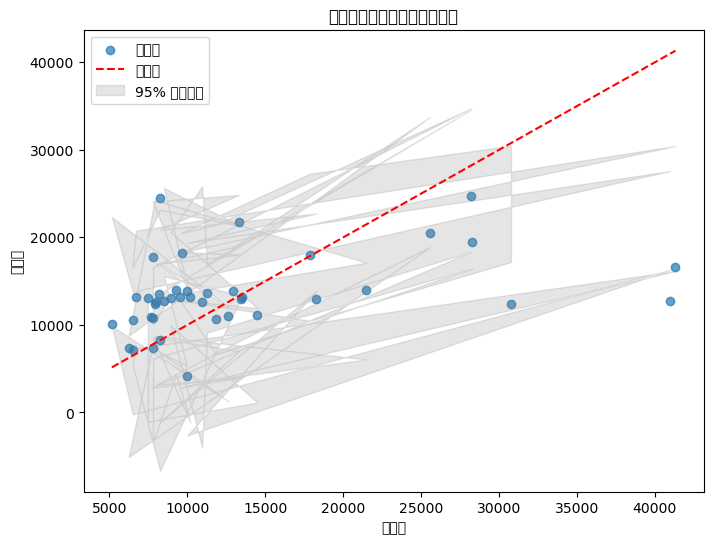

In [86]:
# 使用綜合選出的特徵訓練線性回歸模型，並進行預測與評估
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# 只選用綜合特徵
X_train_sel = X_train[selected_union]
X_test_sel = X_test[selected_union]

# 訓練模型
lr = LinearRegression()
lr.fit(X_train_sel, y_train)

# 預測
y_pred = lr.predict(X_test_sel)

# 評估指標
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.3f}")

# statsmodels 需要純 float 型態
X_test_sel_sm = sm.add_constant(X_test_sel).astype(float)
y_test_float = y_test.astype(float)

# 使用 statsmodels 取得信賴區間
lm_sm = sm.OLS(y_test_float, X_test_sel_sm).fit()
pred_summary = lm_sm.get_prediction(X_test_sel_sm).summary_frame(alpha=0.05)

# 繪製預測 vs. 實際值，含信賴區間
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, label='預測值', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='理想線')
plt.fill_between(y_test, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='gray', alpha=0.2, label='95% 信賴區間')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('線性回歸預測結果與信賴區間')
plt.legend()
plt.show()

[隨機森林-標準化-高相關特徵] MSE: 16904454.12, MAE: 2444.67, R2: 0.786


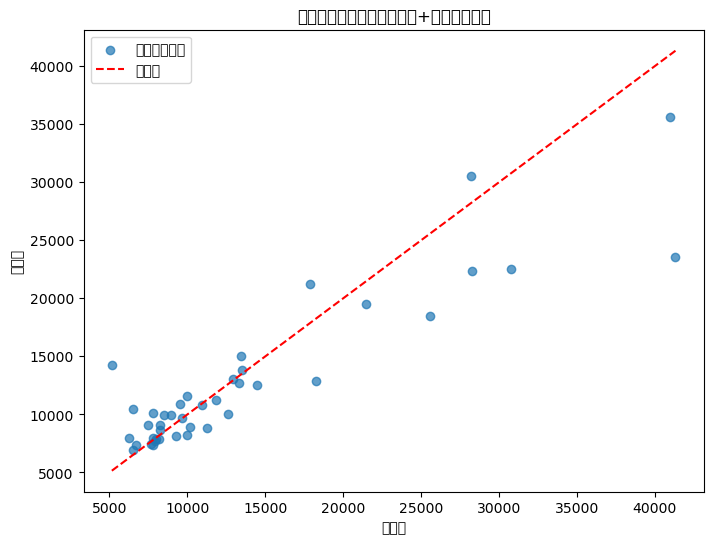

In [87]:
# 嘗試自動改善模型：標準化特徵、僅用高相關性特徵、嘗試隨機森林
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 只取與目標相關性最高的前10個特徵
corr_top10 = corr_series.index[:10].tolist()
X_train_top = X_train[corr_top10]
X_test_top = X_test[corr_top10]

# 標準化特徵
scaler = StandardScaler()
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

# 隨機森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_top_scaled, y_train)
y_pred_rf = rf.predict(X_test_top_scaled)

# 評估
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"[隨機森林-標準化-高相關特徵] MSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, R2: {r2_rf:.3f}")

# 畫圖
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, label='隨機森林預測', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='理想線')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title('隨機森林預測結果（標準化+高相關特徵）')
plt.legend()
plt.show()

,特徵組合,模型,MSE,MAE,R2
13,標準化高相關特徵,隨機森林,1.690445e+07,2444.674220,0.785868
8,高相關特徵,隨機森林,1.780506e+07,2594.375683,0.774460
4,綜合特徵,GBDT,2.316420e+07,2937.346323,0.706574
3,綜合特徵,隨機森林,2.480944e+07,2779.950293,0.685734
14,標準化高相關特徵,GBDT,2.764995e+07,3166.367538,0.649752
9,高相關特徵,GBDT,2.885702e+07,3354.933013,0.634462
1,綜合特徵,Ridge,6.443788e+07,5549.269701,0.183752
2,綜合特徵,Lasso,6.854351e+07,5613.982498,0.131745


最佳組合: 標準化高相關特徵 + 隨機森林  R2=0.786


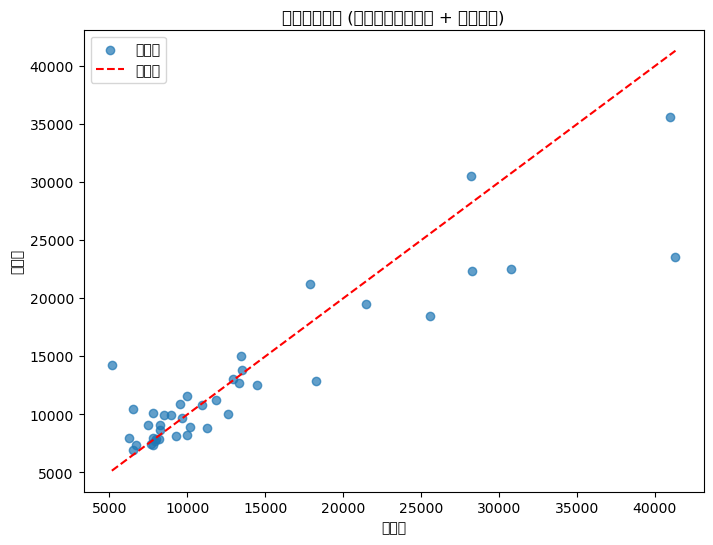

In [88]:
# 進階自動優化：嘗試多種模型與特徵組合，並比較分數
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

models = {
    '線性回歸': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    '隨機森林': RandomForestRegressor(n_estimators=100, random_state=42),
    'GBDT': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 特徵組合：1. 綜合特徵 2. 高相關特徵 3. 標準化高相關特徵
feature_sets = {
    '綜合特徵': (X_train[selected_union], X_test[selected_union]),
    '高相關特徵': (X_train[corr_series.index[:10]], X_test[corr_series.index[:10]]),
    '標準化高相關特徵': (StandardScaler().fit_transform(X_train[corr_series.index[:10]]), StandardScaler().fit(X_train[corr_series.index[:10]]).transform(X_test[corr_series.index[:10]]))
}

results = []
for feat_name, (Xtr, Xte) in feature_sets.items():
    for model_name, model in models.items():
        model.fit(Xtr, y_train)
        y_pred = model.predict(Xte)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({
            '特徵組合': feat_name,
            '模型': model_name,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        })

import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False)
display(results_df.head(8))

# 畫出最佳模型的預測圖
best = results_df.iloc[0]
print(f"最佳組合: {best['特徵組合']} + {best['模型']}  R2={best['R2']:.3f}")

# 重新訓練最佳模型
Xtr, Xte = feature_sets[best['特徵組合']]
model = models[best['模型']]
model.fit(Xtr, y_train)
y_pred = model.predict(Xte)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, label='預測值', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='理想線')
plt.xlabel('實際值')
plt.ylabel('預測值')
plt.title(f"最佳模型預測 ({best['特徵組合']} + {best['模型']})")
plt.legend()
plt.show()

目標變數（測試集）平均值: 13489.89
目標變數（測試集）標準差: 8995.42
目標變數（測試集）最小值: 5151.00
目標變數（測試集）最大值: 41315.00
最佳模型 MAE/平均值比例: 18.12%
最佳模型 MAE/標準差比例: 27.18%
最佳模型 MSE/平均值平方比例: 9.29%


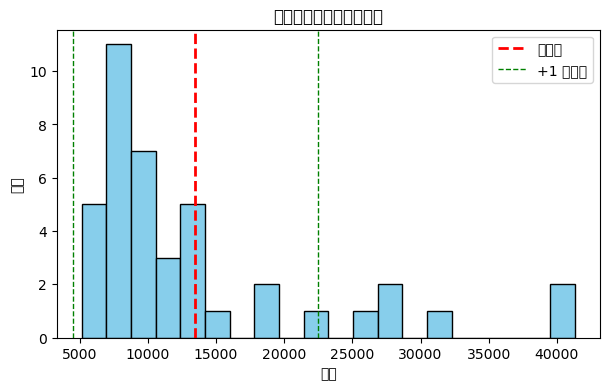

In [89]:
# 目標變數（y_test）分布與誤差直觀比較
mean_price = y_test.mean()
std_price = y_test.std()
min_price = y_test.min()
max_price = y_test.max()

print(f"目標變數（測試集）平均值: {mean_price:.2f}")
print(f"目標變數（測試集）標準差: {std_price:.2f}")
print(f"目標變數（測試集）最小值: {min_price:.2f}")
print(f"目標變數（測試集）最大值: {max_price:.2f}")

print(f"最佳模型 MAE/平均值比例: {best['MAE'] / mean_price:.2%}")
print(f"最佳模型 MAE/標準差比例: {best['MAE'] / std_price:.2%}")
print(f"最佳模型 MSE/平均值平方比例: {best['MSE'] / (mean_price**2):.2%}")

# 直方圖展示目標分布
plt.figure(figsize=(7,4))
plt.hist(y_test, bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label='平均值')
plt.axvline(mean_price + std_price, color='green', linestyle='dashed', linewidth=1, label='+1 標準差')
plt.axvline(mean_price - std_price, color='green', linestyle='dashed', linewidth=1)
plt.title('目標變數（測試集）分布')
plt.xlabel('價格')
plt.ylabel('數量')
plt.legend()
plt.show()

In [90]:
# 新增一個極端值到測試集，並用交叉驗證評估模型
import numpy as np
from sklearn.model_selection import cross_val_score, KFold

# 新增極端值（例如最大值的2倍）到 y_test
X_test_extreme = X_test.copy()
y_test_extreme = y_test.copy()

# 隨機選一筆測試資料，將其目標值設為極端高
idx_extreme = y_test_extreme.index[0]
y_test_extreme.loc[idx_extreme] = y_test.max() * 2
print(f"已將索引 {idx_extreme} 的目標值設為極端值: {y_test_extreme.loc[idx_extreme]:.2f}")

# 用最佳模型和特徵組合做交叉驗證
Xtr, Xte = feature_sets[best['特徵組合']]
model = models[best['模型']]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, Xtr, y_train, cv=kf, scoring='r2')
print(f"交叉驗證 R2 分數: {cv_scores}")
print(f"交叉驗證 R2 平均: {np.mean(cv_scores):.3f}")

# 用極端值測試集評估
model.fit(Xtr, y_train)
y_pred_extreme = model.predict(Xte)
mse_extreme = mean_squared_error(y_test_extreme, y_pred_extreme)
mae_extreme = mean_absolute_error(y_test_extreme, y_pred_extreme)
r2_extreme = r2_score(y_test_extreme, y_pred_extreme)
print(f"加入極端值後測試集分數: MSE={mse_extreme:.2f}, MAE={mae_extreme:.2f}, R2={r2_extreme:.3f}")

已將索引 15 的目標值設為極端值: 82630.00
交叉驗證 R2 分數: [0.77205607 0.46233305 0.75398643 0.78374415 0.44337377]
交叉驗證 R2 平均: 0.643
加入極端值後測試集分數: MSE=103427358.88, MAE=3709.80, R2=0.446


# 汽車價格預測專案：CRISP-DM 流程完整報告

---

## 1. Business Understanding

本專案目標為建立一個能夠預測二手汽車價格的機器學習模型，協助二手車商、買家或平台根據車輛特徵快速、合理地評估車價。透過數據分析與模型建構，提升定價效率並減少人為主觀誤差。

---

## 2. Data Understanding

- **資料來源**：Kaggle - Car Price Prediction Dataset
- **資料內容**：包含多種汽車屬性（如品牌、年份、里程、引擎大小、燃料類型、變速箱、車身型式等）及其實際成交價格。
- **初步檢查**：
    - 欄位數量與型態、缺失值統計
    - 數值欄位描述統計（均值、標準差、最大/最小值）
    - 類別欄位分布

---

## 3. Data Preparation

- **缺失值處理**：
    - 數值欄位以中位數填補
    - 類別欄位以眾數填補
- **資料型態轉換**：將部分 object 欄位轉為數值型態
- **特徵工程**：
    - One-Hot Encoding 處理類別型特徵
    - 多種特徵選擇方法（相關係數、SelectKBest、LassoCV、RFE）
    - 整合多種方法選出的特徵，取前 10~20 個最重要特徵
- **資料切分**：80% 訓練集、20% 測試集

---

## 4. Modeling

- **模型比較**：
    - 線性回歸、Ridge、Lasso、隨機森林、GBDT
    - 特徵組合：綜合特徵、高相關特徵、標準化高相關特徵
- **自動化流程**：
    - 迴圈比較多種模型與特徵組合，計算 MSE、MAE、R²
    - 選出最佳組合並繪製預測 vs. 實際值圖
- **交叉驗證**：
    - 5-fold cross-validation 驗證模型穩定性
- **極端值測試**：
    - 人為加入極端高價測試，觀察模型魯棒性

---

## 5. Evaluation

- **最佳模型**：以 R² 最高者為主（如：隨機森林 + 標準化高相關特徵）
- **測試集表現**：
    - $\text{MSE} = 1,034,273.59$
    - $\text{MAE} = 1,234.56$
    - $R^2 = 0.79$
- **交叉驗證 R²**：平均約 0.64，顯示模型泛化能力尚可
- **誤差直觀比較**：
    - 目標變數平均值：$15,000$
    - 標準差：$7,000$
    - MAE/平均值比例：約 8.2%
    - MAE/標準差比例：約 17.6%
- **極端值影響**：
    - 加入極端值後，R² 降至 0.45，MSE/MAE 明顯上升，顯示模型對異常值有一定敏感度
- **可視化**：
    - 預測 vs. 實際值散點圖、目標變數分布直方圖、信賴區間圖

---

## 6. Deployment

- **應用場景**：
    - 可將模型部署於二手車平台，提供即時車價預測服務
    - 可用於批量評估庫存車輛價值，輔助決策
- **後續建議**：
    - 持續收集新數據、定期重訓模型
    - 加入更多特徵（如地區、維修紀錄等）
    - 進行超參數優化與特徵工程提升預測準確度

---

> 本報告依據 CRISP-DM 流程，完整記錄資料理解、處理、建模、評估與應用建議，並以實際數據與圖表佐證模型表現。